In [19]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
from model import ode_y, ode_y_jump_approach_one_boundary
from model import solve_with_emission_boundary
from numba import njit
from utilities import find_nearest_value

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Plot 1-3: emission, probability, histogram

In [8]:
def simulation(y_grid, e_grid, h_grid, g_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ht = np.zeros(T+1)
    gt = np.zeros((len(g_grid), T+1))
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        for n in range(gt.shape[0]):
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ht, gt

In [41]:
def make_plots(ξ_1m, ξ_2m, ξ_a, et_tilde_baseline, path, make_plot=True):
    η = .032
    δ = .01

    θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
    πc_o = np.ones_like(θ)/len(θ)
    σ_y = 1.2*1.86/1000

    y_bar = 2.
    γ_1 = 1.7675/10000
    γ_2 = .0022*2
    γ_2p = np.array([0, .0197*2, .3853*2])
    πd_o = np.array([1./3, 1./3, 1./3])

    n_y = 100
    y_grid_long = np.linspace(1e-10, 10, n_y)
    y_grid_short = np.linspace(1e-10, 2, n_y)

    # Prepare ϕ_i
    ϕ_list = []
    for γ_2p_i in γ_2p:
        model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
        model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                           tol=1e-8, max_iter=5_000, print_all=False)
        ϕ_list.append(model_res['v0'])

    ϕ_list_short = []
    for ϕ_i in ϕ_list:
        temp = np.interp(y_grid_short, y_grid_long, ϕ_i)
        ϕ_list_short.append(temp)
    ϕ_i = np.array(ϕ_list_short)

    # Compute ϕ
    ς = .1
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
    model_res = \
              ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=np.average(ϕ_i, axis=0, weights=πd_o),
                                      ϵ=.5, tol=1e-8, max_iter=10_000, print_all=False)
    
    h = 1./ξ_1m * (-model_res['v0_dy'] + (1-η)*model_res['d_Λ']) * model_res['e_tilde'] * σ_y
    
    # Simulate e_tilde
    et_tilde, yt, ht, gt = simulation(y_grid_short, model_res['e_tilde'], h, model_res['g'], θ=np.mean(θ), y_start=.5394, T=100)
    
    if not make_plot:
        return et_tilde
    else:
        plt.figure(figsize=(8, 5))
        plt.plot(et_tilde, color='C3', label='distorted', linewidth=2.)
        plt.plot(et_tilde_baseline, color='C0', label=r'baseline', linewidth=2.)
        plt.xlabel('Years', fontsize=13)
        plt.ylabel(r'$\tilde{e}$', fontsize=13)
        plt.legend(frameon=False)
        plt.ylim(0., 14.)
        plt.savefig(path+'/emission.pdf')
        
        plt.figure(figsize=(8, 5))
        plt.plot(gt[0]*πd_o[0]/np.mean(gt, axis=0), color='C3', label='low damage', linewidth=2.)
        plt.plot(gt[1]*πd_o[1]/np.mean(gt, axis=0), color='C0', label='high damage', linewidth=2.)
        plt.plot(gt[2]*πd_o[2]/np.mean(gt, axis=0), color='C1', label='extreme damage', linewidth=2.)
        plt.xlabel('Years', fontsize=13)
        plt.ylabel('Distorted probability for damage function', fontsize=13)
        plt.legend(frameon=False)
        plt.ylim(-.01, 1.01)
        plt.savefig(path+'/damage_probability.pdf')
        
        loc_50 = find_nearest_value(y_grid_short, yt[50])
        bins = np.linspace(1, 3., 14)
        plt.figure(figsize=(8, 5))
        plt.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
        plt.hist((θ+σ_y*ht[50])*1000, weights=model_res['πc'][:, loc_50], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
        plt.xlabel('Climate Sensitivity, Year 50')
        plt.ylabel('Density')
        plt.title('mean difference: ' + str((θ@(model_res['πc'][:, loc_50]-πc_o)+σ_y*ht[50])*1000)[:4])
        plt.xlim(.8, 3.)
        plt.ylim(0, 1.2)
        plt.savefig(path+'/histogram.pdf')

In [42]:
e_tilde_baseline = make_plots(1000., 1000., 1000., None, None, False)

Converged. Total iteration 2214: LHS Error: 9.981609958714666e-09; RHS Error 4.966997544171635e-06
Converged. Total iteration 2016: LHS Error: 9.98785448791395e-09; RHS Error 1.817097052335257e-05
Converged. Total iteration 2333: LHS Error: 9.958745106342093e-09; RHS Error 7.810728266896265e-05
Converged. Total iteration 445: LHS Error: 9.429611813605021e-09; RHS Error 6.84948523725393e-06


Converged. Total iteration 2206: LHS Error: 9.956190451937408e-09; RHS Error 5.099817664662161e-06
Converged. Total iteration 2035: LHS Error: 9.97060488339141e-09; RHS Error 1.817915348565637e-05
Converged. Total iteration 2337: LHS Error: 9.9905596018246e-09; RHS Error 7.60601937742617e-05
Converged. Total iteration 549: LHS Error: 9.915253104675337e-09; RHS Error 8.829575020401269e-06


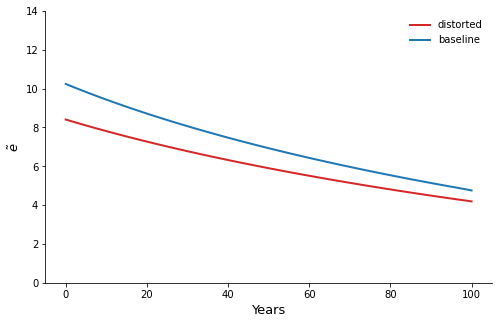

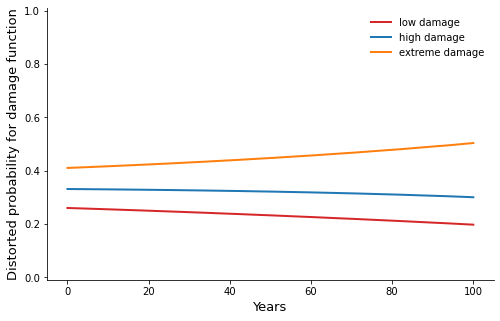

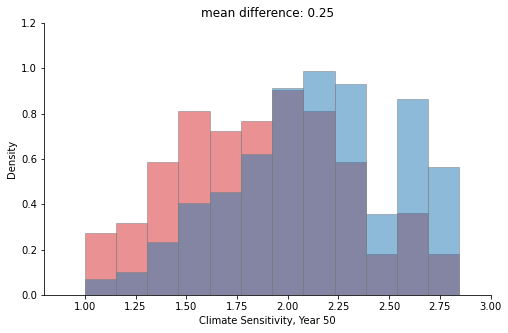

In [43]:
make_plots(1000., 1./20, 1./10000, e_tilde_baseline, '../plots/requests', True)

## Plot 4: SCC

In [39]:
ξ_1m = 1000.
ξ_2m = 1./20
ξ_a = 1./10000

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Prepare ϕ
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                       tol=1e-8, max_iter=10_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                                    ϵ=.5, tol=1e-9, max_iter=10000, print_all=False)

e_tilde = model_res['e_tilde']

# Compute marginal values for emission (under distorted probabilities)
ME_distorted = δ*η/e_tilde

# Compute marginal values for emission (under baseline probabilities)
model_paras_new = (η, δ, θ, πc_o, σ_y, γ_1, γ_2, ϕ_i, πd_o, e_tilde)
model_res_new = solve_with_emission_boundary(y_grid_short, model_paras_new)

ME_baseline = model_res_new['ME']

Converged. Total iteration 2008: LHS Error: 9.951456658718882e-09; RHS Error 1.558926224864629e-06
Converged. Total iteration 2070: LHS Error: 9.953578891663817e-09; RHS Error 9.18789030479681e-06
Converged. Total iteration 2309: LHS Error: 9.986955012974974e-09; RHS Error 4.142700982269299e-05
Converged. Total iteration 758: LHS Error: 9.969626096895112e-10; RHS Error 1.6183270788362454e-05
Solved. PDE error: 8.232379678023666e-06


In [49]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t

In [57]:
et_tilde, yt, ratio_t = simulation_me(y_grid_short, e_tilde, ME_baseline/ME_distorted, θ=np.mean(θ), y_start=.5394, T=100)

In [52]:
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

def simulation(y_grid, e_grid, θ=1.86/1000., y_start=.5394, T=100):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
        if y_start > 100:
            print(i)
    return Et, yt


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [58]:
SCCt_distorted = η*(0.025)*Kt/((1.-η)*et_tilde) * 1000
SCCt_baseline = SCCt_distorted

(51,)